In [ ]:
pip install imgaug

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
import pickle
from PIL import Image
import time
import os
from PIL import Image
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import random

start = time.time()

In [16]:
TRAIN_DIR_MildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/MildDemented'
TRAIN_DIR_ModerateDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/ModerateDemented'
TRAIN_DIR_NonDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/NonDemented'
TRAIN_DIR_VeryMildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented'
TRAIN_DIR=[]
TRAIN_DIR.append(TRAIN_DIR_MildDemented)
TRAIN_DIR.append(TRAIN_DIR_ModerateDemented)
TRAIN_DIR.append(TRAIN_DIR_NonDemented)
TRAIN_DIR.append(TRAIN_DIR_VeryMildDemented)

TEST_DIR_MildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/MildDemented'
TEST_DIR_ModerateDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/ModerateDemented'
TEST_DIR_NonDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/NonDemented'
TEST_DIR_VeryMildDemented = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test/VeryMildDemented'
TEST_DIR=[]
TEST_DIR.append(TEST_DIR_MildDemented)
TEST_DIR.append(TEST_DIR_ModerateDemented)
TEST_DIR.append(TEST_DIR_NonDemented)
TEST_DIR.append(TEST_DIR_VeryMildDemented)


dim = 150

test_split_percent = .1       # % of total data for testing                                         .1
validation_split_percent = .2 # % of total data for validation                                      .2
layers_unlocked = True        # unlock the imported pre-training layers?                            False  
momentum = .9                 # momentum of SGD                                                     .9

train_images=[]
test_images=[]


In [ ]:
def augmentation(input_img):
    list_data=[]
    datagen = ImageDataGenerator(
        rotation_range=40, width_shift_range=0.2,
        height_shift_range=0.2,  shear_range=0.2,
        zoom_range=0.2, horizontal_flip=True,
        fill_mode='nearest')
    img = input_img
    i=0
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,)+x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    for batch in datagen.flow(x, batch_size=1):
        list_data.append(img_to_array(batch[0]))
        i += 1
        if i ==2:
            break 

    return list_data

In [17]:
def create_label_train(path):
    if TRAIN_DIR.index(path)==0:
        return np.array([1,0,0,0])
    if TRAIN_DIR.index(path)==1:
        return np.array([0,1,0,0])
    if TRAIN_DIR.index(path)==2:
        return np.array([0,0,1,0])
    if TRAIN_DIR.index(path)==3:
        return np.array([0,0,0,1])

def create_label_test(path):
    if TEST_DIR.index(path)==0:
        return np.array([1,0,0,0])
    if TEST_DIR.index(path)==1:
        return np.array([0,1,0,0])
    if TEST_DIR.index(path)==2:
        return np.array([0,0,1,0])
    if TEST_DIR.index(path)==3:
        return np.array([0,0,0,1])
   

In [18]:

def create_train_data():
    training_data = []

    for path_TRAIN_DIR in tqdm(TRAIN_DIR):
        for img in os.listdir(path_TRAIN_DIR):
            
            label=create_label_train(path_TRAIN_DIR)
            path = os.path.join(path_TRAIN_DIR, img)
            img_data = cv2.imread(path,1) 
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            img_data = cv2.resize(img_data, (dim,dim))
           
            training_data.append([img_data,label])

    random.shuffle(training_data)

    return training_data


In [19]:
def create_test_data():
    test_data = []

    for path_Test_DIR in tqdm(TEST_DIR):
           for img in os.listdir(path_Test_DIR):
                
            label=create_label_test(path_Test_DIR)
            path = os.path.join(path_Test_DIR, img)
            img_data = cv2.imread(path,1) 
            img_data = cv2.cvtColor(img_data, cv2.COLOR_BGR2RGB)
            img_data = cv2.resize(img_data, (dim,dim))
           
            test_data.append([ np.array(img_data),label ])
       

    #random.shuffle(test_data)
    return test_data

In [20]:
train_images = create_train_data()
X_train = np.array([i[0] for i in train_images])
y_train =[i[1] for i in train_images]

test_images = create_test_data()
X_test = np.array([i[0] for i in test_images])
y_test = [i[1] for i in test_images]

class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']

print(X_train.shape)
print(X_test.shape)


100%|██████████| 4/4 [00:01<00:00,  2.90it/s]

(5121, 150, 150, 3)
(1279, 150, 150, 3)


Text(0.5, 1.0, '[1 0 0 0]')

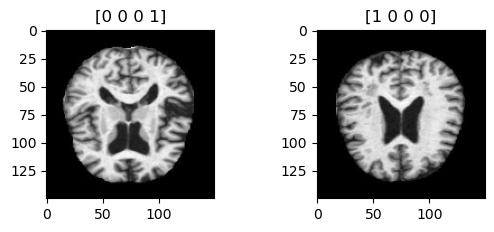

In [21]:
plt.subplot(221)
plt.imshow(X_train[1,:,:,:])
plt.title(y_train[1])

plt.subplot(222)
plt.imshow(X_test[1,:,:,:])
plt.title(y_test[1])

In [22]:
# cocatenate arrays, combining all data
total_data = np.concatenate((X_train,X_test))
total_labels = np.concatenate((y_train,y_test))
print(total_data.shape)
print(total_labels.shape)

(6400, 150, 150, 3)
(6400, 4)


In [23]:
# train test split

split = 0.2


# split into (training+ validation) and test 
train_val_data, test_data, train_val_labels, test_labels = train_test_split(total_data,total_labels,
                                                                            test_size=split)

# split (train + validation) into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_val_data,train_val_labels,
                                                                test_size=split)


print('test',test_data.shape)

test (1280, 150, 150, 3)


In [24]:
# Check array dimensions
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(4096, 150, 150, 3)
(4096, 4)
(1024, 150, 150, 3)
(1024, 4)
(1280, 150, 150, 3)
(1280, 4)


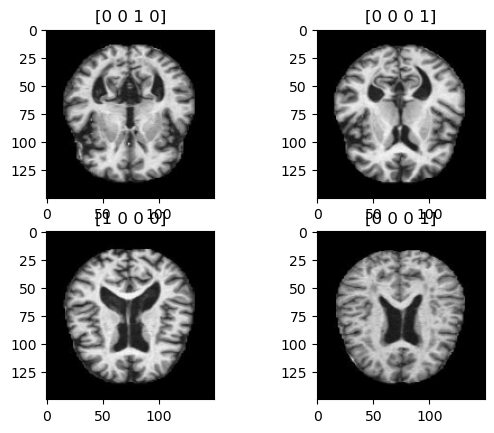

Text(0.5, 1.0, '[0 0 0 1]')

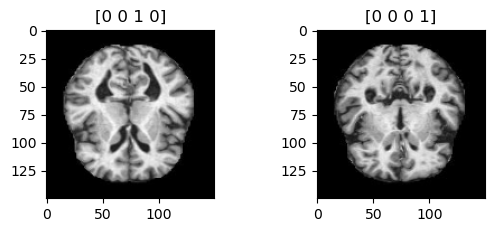

In [25]:
# check some images
plt.subplot(221)
plt.imshow(train_data[1,:,:,:])
plt.title(train_labels[7])
plt.subplot(222)

plt.imshow(train_data[150,:,:,:])
plt.title(train_labels[150])
plt.subplot(223)

plt.imshow(val_data[45,:,:,:])
plt.title(val_labels[45])
plt.subplot(224)

plt.imshow(val_data[4,:,:,:])
plt.title(val_labels[4])
plt.show()

plt.subplot(221)
plt.imshow(test_data[70,:,:,:])
plt.title(test_labels[70])

plt.subplot(222)
plt.imshow(test_data[140,:,:,:])
plt.title(test_labels[140])

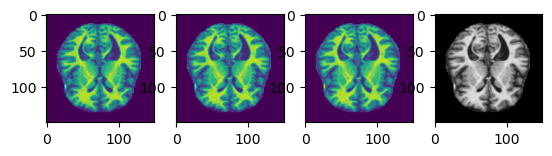

In [26]:
# check image channels
plt.subplot(141)
plt.imshow(train_data[3,:,:,0])
plt.subplot(142)
plt.imshow(train_data[3,:,:,1])
plt.subplot(143)
plt.imshow(train_data[3,:,:,2])
plt.subplot(144)
plt.imshow(train_data[3,:,:,:])

In [27]:
# import pre-trained VGG16 model

vg_model = tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet',input_shape=(150,150,3), pooling = 'max') #added pooling

## Add new trainable FC layers ##
flat = Flatten()(vg_model.output)
fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
dp1 = Dropout(0.1)(fc1)                                                   # changed dropout here from .5
output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax


Fold 1/5
Epoch 1/30
1366/1366 [==============================] - 77s 32ms/step - loss: 1.2074 - accuracy: 0.4788 - val_loss: 1.0633 - val_accuracy: 0.5137
Epoch 2/30
1366/1366 [==============================] - 44s 32ms/step - loss: 1.0156 - accuracy: 0.4978 - val_loss: 0.9601 - val_accuracy: 0.5605
Epoch 3/30
1366/1366 [==============================] - 42s 31ms/step - loss: 0.9608 - accuracy: 0.5256 - val_loss: 0.9508 - val_accuracy: 0.5371
Epoch 4/30
1366/1366 [==============================] - 42s 31ms/step - loss: 0.9333 - accuracy: 0.5410 - val_loss: 0.8945 - val_accuracy: 0.5791
Epoch 5/30
1366/1366 [==============================] - 42s 31ms/step - loss: 0.9095 - accuracy: 0.5457 - val_loss: 0.8598 - val_accuracy: 0.5898
Epoch 6/30
1366/1366 [==============================] - 44s 32ms/step - loss: 0.8929 - accuracy: 0.5554 - val_loss: 0.8393 - val_accuracy: 0.5977
Epoch 7/30
1366/1366 [==============================] - 42s 31ms/step - loss: 0.8625 - accuracy: 0.5723 - val_loss:

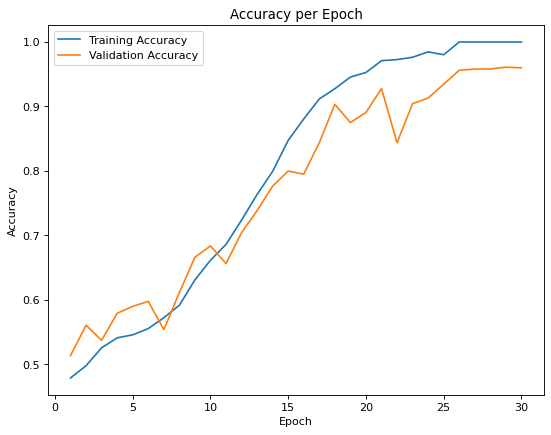

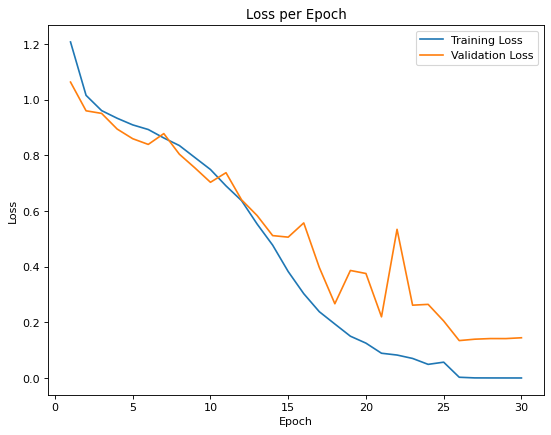

image dimensions:  150
validation split percentage:  0.2
epochs:  30
Model trained from scratch? :  True
Total Time Elapsed = 64 minutes
Fold 2/5
Epoch 1/30
1366/1366 [==============================] - 47s 33ms/step - loss: 1.3040 - accuracy: 0.4893 - val_loss: 1.0837 - val_accuracy: 0.4785
Epoch 2/30
1366/1366 [==============================] - 45s 33ms/step - loss: 1.0132 - accuracy: 0.5029 - val_loss: 0.9982 - val_accuracy: 0.5322
Epoch 3/30
1366/1366 [==============================] - 44s 33ms/step - loss: 0.9861 - accuracy: 0.5112 - val_loss: 1.0569 - val_accuracy: 0.4951
Epoch 4/30
1366/1366 [==============================] - 43s 31ms/step - loss: 0.9542 - accuracy: 0.5422 - val_loss: 0.9411 - val_accuracy: 0.5498
Epoch 5/30
1366/1366 [==============================] - 44s 32ms/step - loss: 0.9234 - accuracy: 0.5645 - val_loss: 0.9093 - val_accuracy: 0.5771
Epoch 6/30
1366/1366 [==============================] - 44s 32ms/step - loss: 0.8987 - accuracy: 0.5786 - val_loss: 0.9000 -

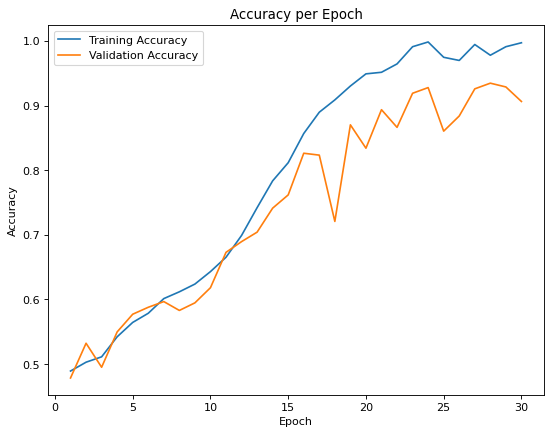

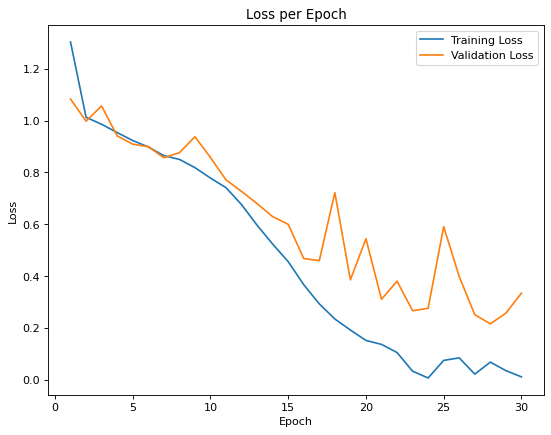

image dimensions:  150
validation split percentage:  0.2
epochs:  30
Model trained from scratch? :  True
Total Time Elapsed = 86 minutes
Fold 3/5
Epoch 1/30
1366/1366 [==============================] - 45s 31ms/step - loss: nan - accuracy: 0.1389 - val_loss: nan - val_accuracy: 0.1465
Epoch 2/30
1366/1366 [==============================] - 44s 32ms/step - loss: nan - accuracy: 0.1379 - val_loss: nan - val_accuracy: 0.1465
Epoch 3/30
1366/1366 [==============================] - 44s 32ms/step - loss: nan - accuracy: 0.1379 - val_loss: nan - val_accuracy: 0.1465
Epoch 4/30
1366/1366 [==============================] - 44s 32ms/step - loss: nan - accuracy: 0.1379 - val_loss: nan - val_accuracy: 0.1465
Epoch 5/30
1366/1366 [==============================] - 42s 31ms/step - loss: nan - accuracy: 0.1379 - val_loss: nan - val_accuracy: 0.1465
Epoch 6/30
1366/1366 [==============================] - 42s 31ms/step - loss: nan - accuracy: 0.1379 - val_loss: nan - val_accuracy: 0.1465
Epoch 7/30
136

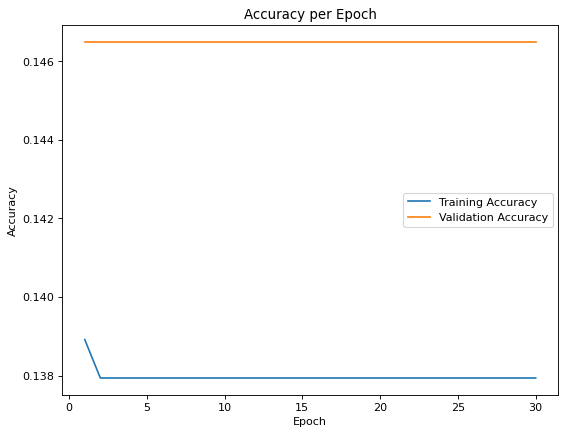

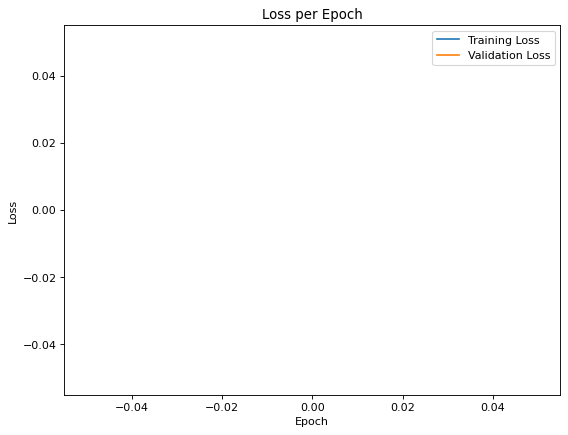

image dimensions:  150
validation split percentage:  0.2
epochs:  30
Model trained from scratch? :  True
Total Time Elapsed = 108 minutes
Fold 4/5
Epoch 1/30
1366/1366 [==============================] - 46s 31ms/step - loss: 1.1986 - accuracy: 0.4829 - val_loss: 1.0377 - val_accuracy: 0.5000
Epoch 2/30
1366/1366 [==============================] - 43s 31ms/step - loss: 1.0152 - accuracy: 0.5137 - val_loss: 0.9915 - val_accuracy: 0.5078
Epoch 3/30
1366/1366 [==============================] - 43s 31ms/step - loss: 0.9529 - accuracy: 0.5391 - val_loss: 0.9102 - val_accuracy: 0.5791
Epoch 4/30
1366/1366 [==============================] - 43s 31ms/step - loss: 0.9186 - accuracy: 0.5706 - val_loss: 0.9185 - val_accuracy: 0.5947
Epoch 5/30
1366/1366 [==============================] - 44s 32ms/step - loss: 0.8812 - accuracy: 0.5903 - val_loss: 0.8557 - val_accuracy: 0.6045
Epoch 6/30
1366/1366 [==============================] - 44s 33ms/step - loss: 0.8564 - accuracy: 0.6082 - val_loss: 0.8606 

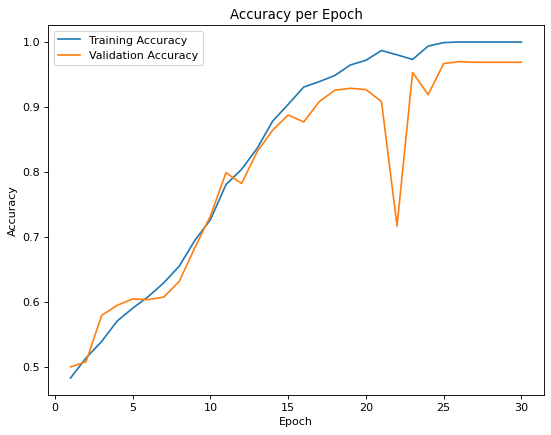

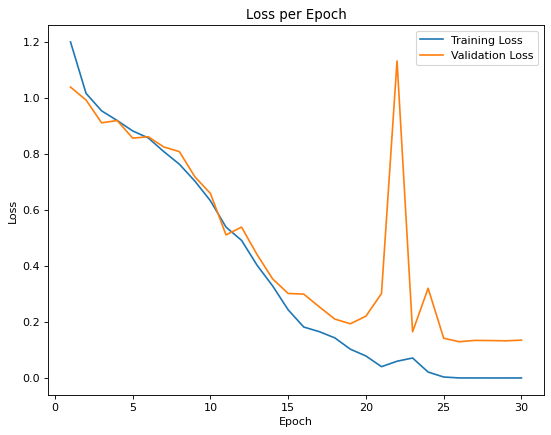

image dimensions:  150
validation split percentage:  0.2
epochs:  30
Model trained from scratch? :  True
Total Time Elapsed = 131 minutes
Fold 5/5
Epoch 1/30
1366/1366 [==============================] - 46s 32ms/step - loss: 1.1501 - accuracy: 0.4778 - val_loss: 1.0530 - val_accuracy: 0.5020
Epoch 2/30
1366/1366 [==============================] - 44s 32ms/step - loss: 1.0089 - accuracy: 0.5103 - val_loss: 0.9605 - val_accuracy: 0.5244
Epoch 3/30
1366/1366 [==============================] - 44s 32ms/step - loss: 0.9394 - accuracy: 0.5549 - val_loss: 0.9117 - val_accuracy: 0.5342
Epoch 4/30
1366/1366 [==============================] - 44s 32ms/step - loss: 0.8935 - accuracy: 0.5701 - val_loss: 0.9153 - val_accuracy: 0.5439
Epoch 5/30
1366/1366 [==============================] - 45s 33ms/step - loss: 0.8415 - accuracy: 0.5928 - val_loss: 0.9236 - val_accuracy: 0.5098
Epoch 6/30
1366/1366 [==============================] - 44s 32ms/step - loss: 0.7913 - accuracy: 0.6294 - val_loss: 0.7299 

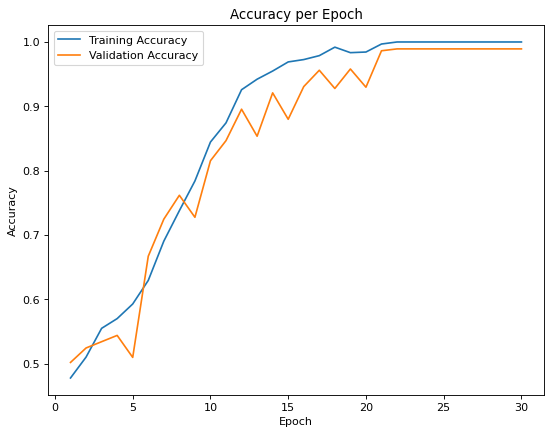

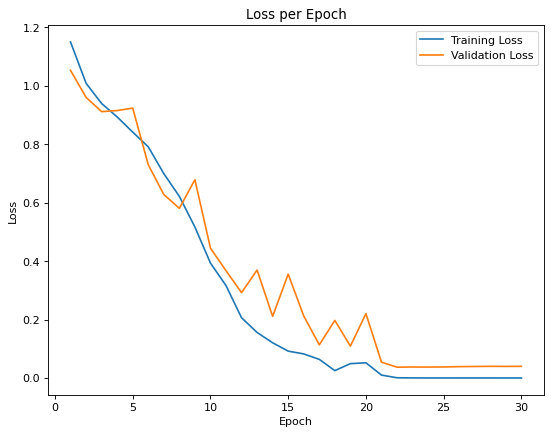

image dimensions:  150
validation split percentage:  0.2
epochs:  30
Model trained from scratch? :  True
Total Time Elapsed = 153 minutes
Accuracy: 0.80 (+/- 0.33)


In [41]:
eps=30

from sklearn.model_selection import KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)


# Use KFold to train and evaluate the model on each fold
scores = []

for i, (train_index, val_index) in enumerate(kf.split(train_val_data)):
    vg_model = tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet',input_shape=(150,150,3), pooling = 'max') #added pooling

    ## Add new trainable FC layers ##
    flat = Flatten()(vg_model.output)
    fc1 = Dense(1024,activation='relu', kernel_initializer='he_uniform')(flat) # put in kernel initializer he-uniform
    dp1 = Dropout(0.1)(fc1)                                                   # changed dropout here from .5
    output = Dense(4,activation='softmax')(dp1)                                # changed to sigmoid from softmax

    vg_model = Model(inputs=vg_model.inputs, outputs=output)
    print(f"Fold {i+1}/{num_folds}")
    # Split the training data into training and validation sets for this fold
    X_train_fold, X_val_fold = train_val_data[train_index], train_val_data[val_index]
    y_train_fold, y_val_fold = train_val_labels[train_index], train_val_labels[val_index]
    # compile the model
    #changed from tf.keras.optimizers.Adam(learning_rate=.0001) to SGD+nest.+momentum
    opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=momentum, nesterov=True,name='SGD') 
    from keras.callbacks import EarlyStopping

    # Fit the model on the training data for this fold, using early stopping to prevent overfitting

    vg_model.compile(optimizer=opt, loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
     # train the model
    model_history = vg_model.fit(X_train_fold,y_train_fold,validation_data=(X_val_fold,y_val_fold)
                             ,epochs=30,batch_size=3, shuffle=True) #changed batch size from 15
    # Evaluate the model on the testing data for this fold
    score = vg_model.evaluate(test_data, test_labels, verbose=0)
    print(score)
    plot(eps,model_history)
    scores.append(score[1])
# Print the mean score and standard deviation across all folds
print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(scores), np.std(scores)))

# Plots and Values

In [54]:
print('fold 1:',scores[0])
print('fold 2:',scores[1])
print('fold 3:',scores[2])
print('fold 4:',scores[3])
print('fold 5:',scores[4])
score1=[]
score1.append(scores[0])
score1.append(scores[1])
score1.append(scores[3])
score1.append(scores[4])

print("AVG Accuracy: %0.2f (+/- %0.2f)" % (np.mean(score1), np.std(score1)))
print("MAX Accuracy: %0.2f (+/- %0.2f)" % (np.max(scores), np.std(scores)))

fold 1: 0.97265625
fold 2: 0.91015625
fold 3: 0.14140625298023224
fold 4: 0.9781249761581421
fold 5: 0.9781249761581421
AVG Accuracy: 0.96 (+/- 0.03)
MAX Accuracy: 0.98 (+/- 0.33)


In [ ]:
# plot accuracy
def plot(eps,model_history):
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Accuracy per Epoch')
    plt.plot(np.linspace(1,eps,num=eps),model_history.history['accuracy'], label = 'Training Accuracy')
    plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_accuracy'], label = 'Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    # print(np.amax.model_history.history['val_acc'])

    #Plot loss
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.title('Loss per Epoch')
    plt.plot(np.linspace(1,eps,num=eps),model_history.history['loss'], label = 'Training Loss')
    plt.plot(np.linspace(1,eps,num=eps),model_history.history['val_loss'], label = 'Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # print out variable values
    print('image dimensions: ',dim)
    print('validation split percentage: ',validation_split_percent)
    print('epochs: ',eps)
    print('Model trained from scratch? : ',layers_unlocked)
    end = time.time()
    print('Total Time Elapsed = %.2d minutes'%((end - start)/60))

# Saving the Model

In [ ]:
# ## saving in HDF5 format

vg_model.save('vgg19_epochs30_testacc98.h5')






# Load Model

In [ ]:


#vg_model = load_model("/kaggle/input/valsplit20-epochs50-testacc98h5/valsplit20_epochs50_testacc98.h5") 
